In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas
from skmap.misc import find_files, GoogleSheet, ttprint
import warnings
import time
from scipy.special import expit, logit
import warnings
import joblib
import pickle
from pathlib import Path
from trees_rf import TreesRandomForestRegressor
from model_fit import read_features, cfi_calc, parameter_fine_tuning, calc_ccc, separate_data, rscfi 
from model_fit import accuracy_plot, plot_top_features, pdp_hexbin, plot_histogram, calc_metrics, accuracy_strata_plot
import warnings
warnings.filterwarnings('ignore')
import os
import json
from datetime import datetime

data_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube/soil_property_model_pipeline'
prop_list = ['soc', 'ocd','bulk.density.fe','ph.cacl2', 'ph.h2o','total.n', 'carbonates', 'extractable.p', 'extractable.k','cec'] #'coarse.mass', 'coarse.vol', 'bulk.density.tot', 'ec', 

space_list = ['log1p','log1p','normal','normal','normal','log1p','log1p','log1p','log1p','log1p'] 
version = '20250212'


In [2]:
def calc_picp(lower_bounds, upper_bounds, true_values):
    within_bounds = np.sum((true_values >= lower_bounds) & (true_values <= upper_bounds))
    picp = within_bounds / len(true_values)
    return picp

def calc_qcp(predictions, true_values, quantile):
    return np.mean(true_values <= predictions)

# Uncertainty evaluation
### this is only done for random forest

[10:24:53] processing soc-----------------------------------


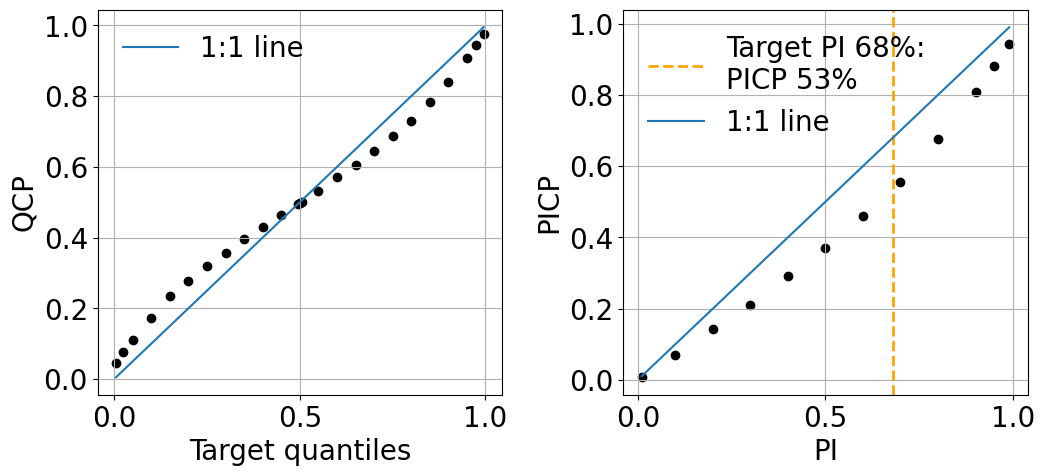

[10:25:04] processing ocd-----------------------------------


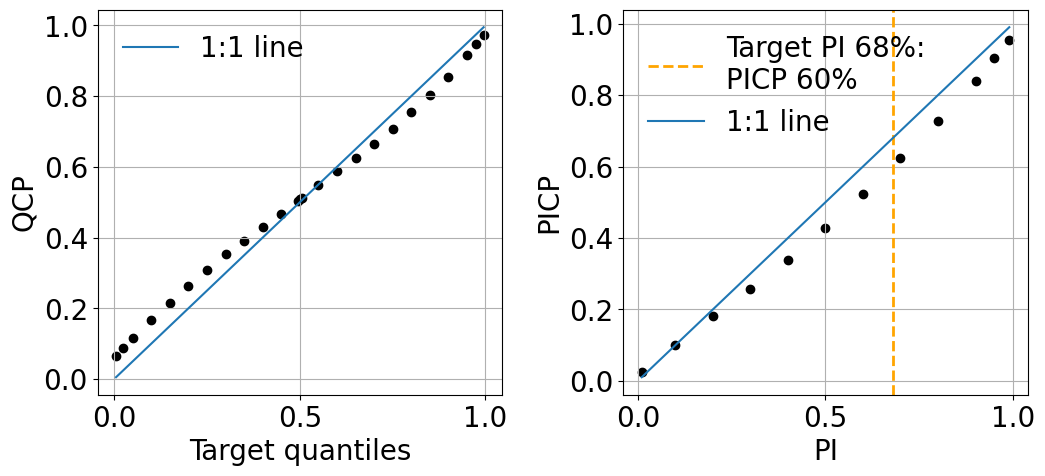

[10:25:08] processing bulk.density.fe-----------------------------------


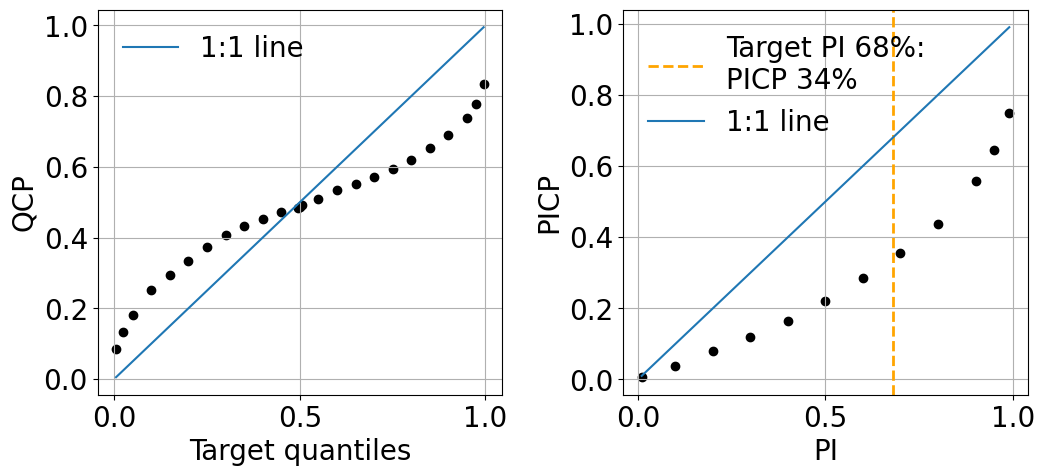

[10:25:09] processing ph.cacl2-----------------------------------


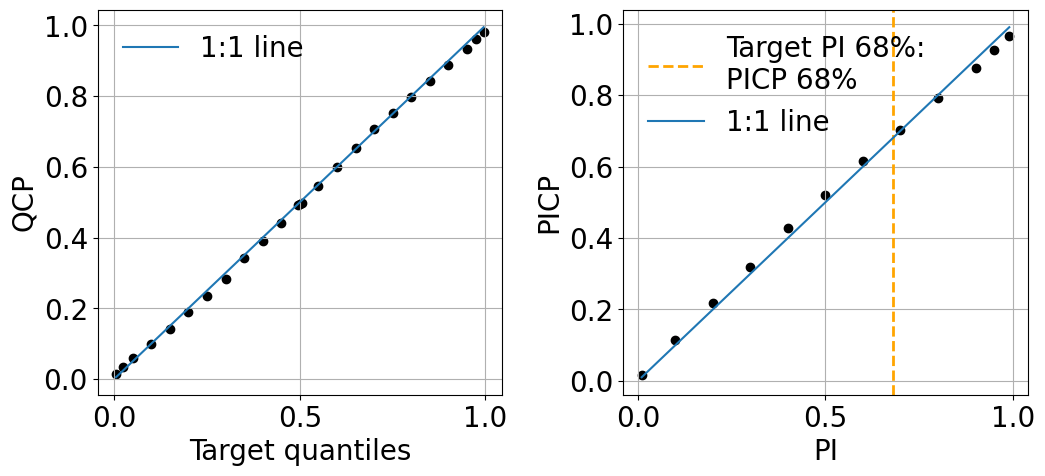

[10:25:19] processing ph.h2o-----------------------------------


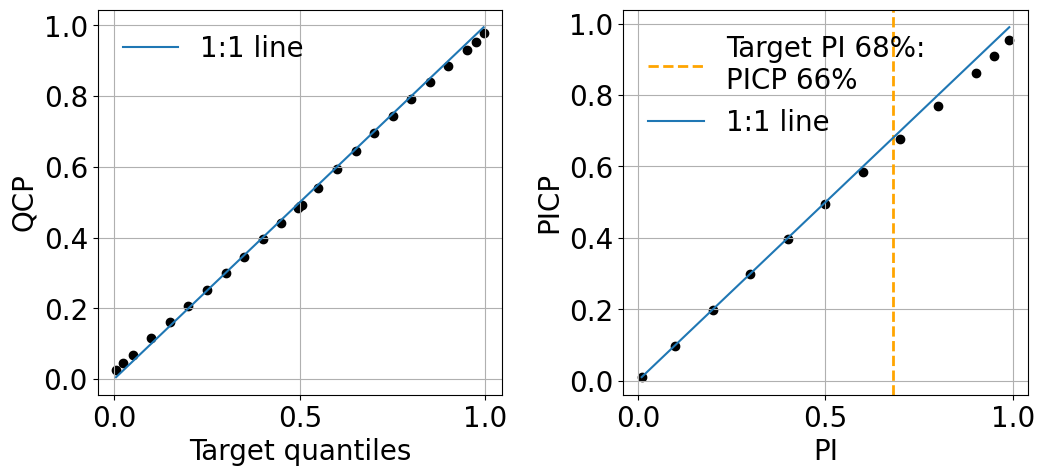

[10:25:25] processing total.n-----------------------------------


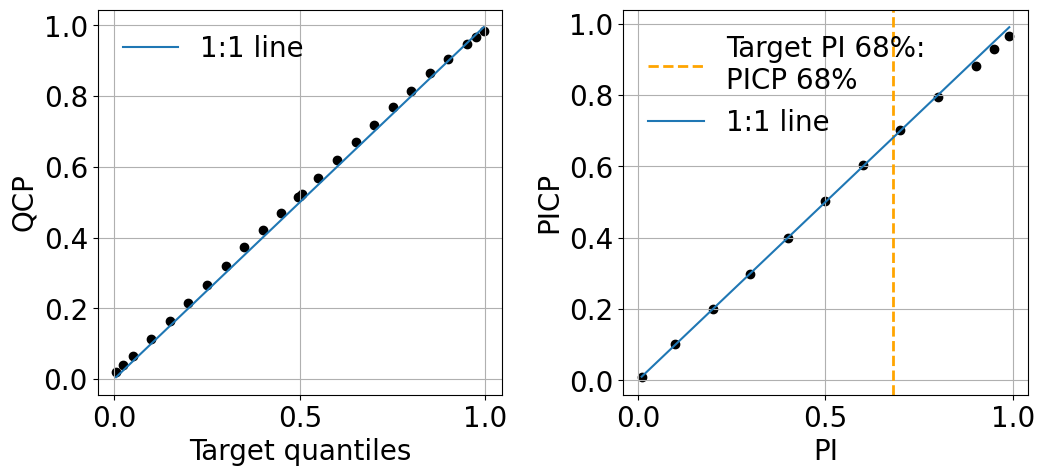

[10:25:29] processing carbonates-----------------------------------


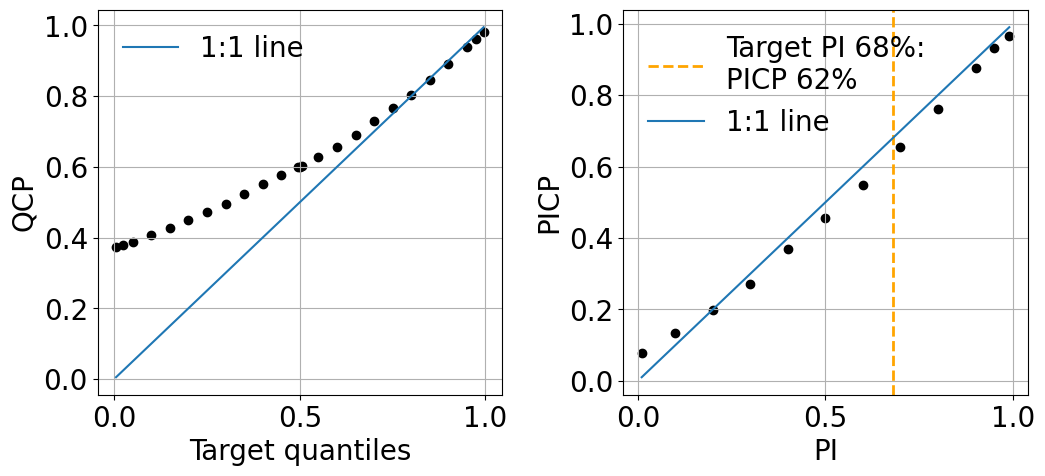

[10:25:33] processing extractable.p-----------------------------------


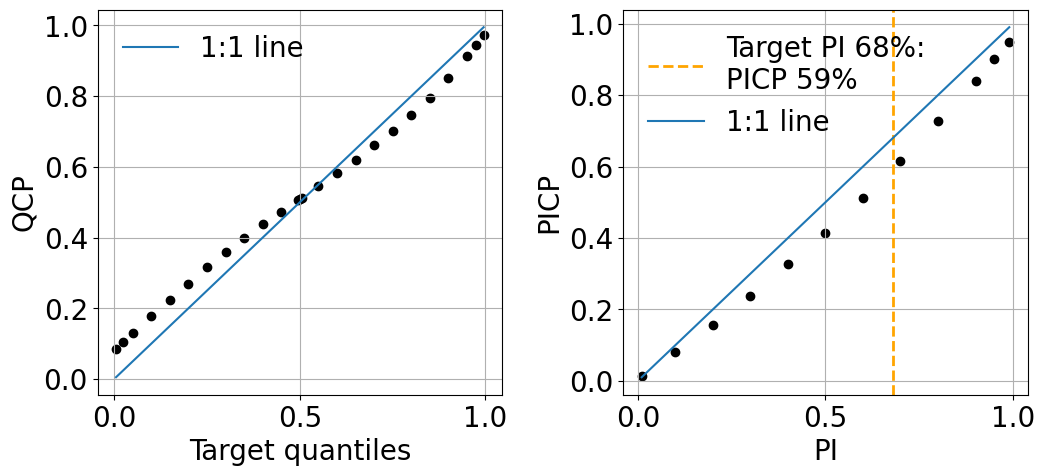

[10:25:40] processing extractable.k-----------------------------------


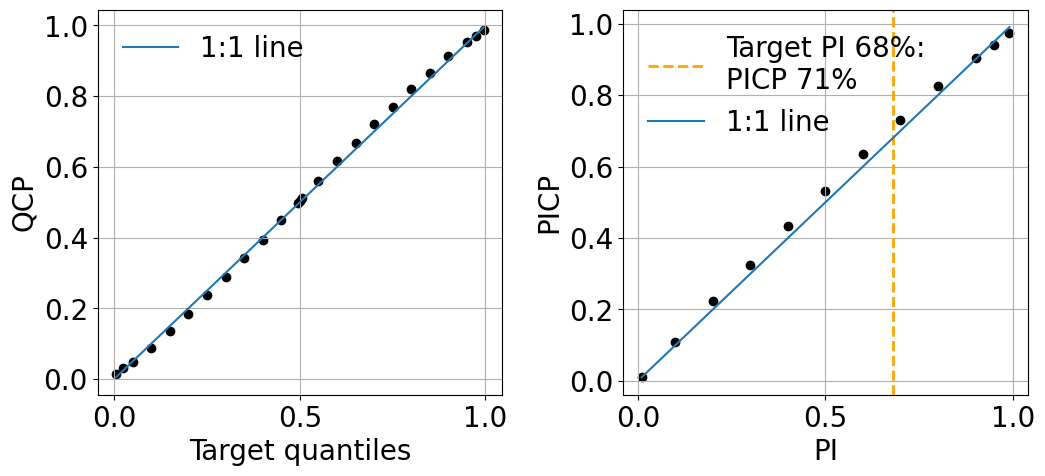

[10:25:48] processing cec-----------------------------------


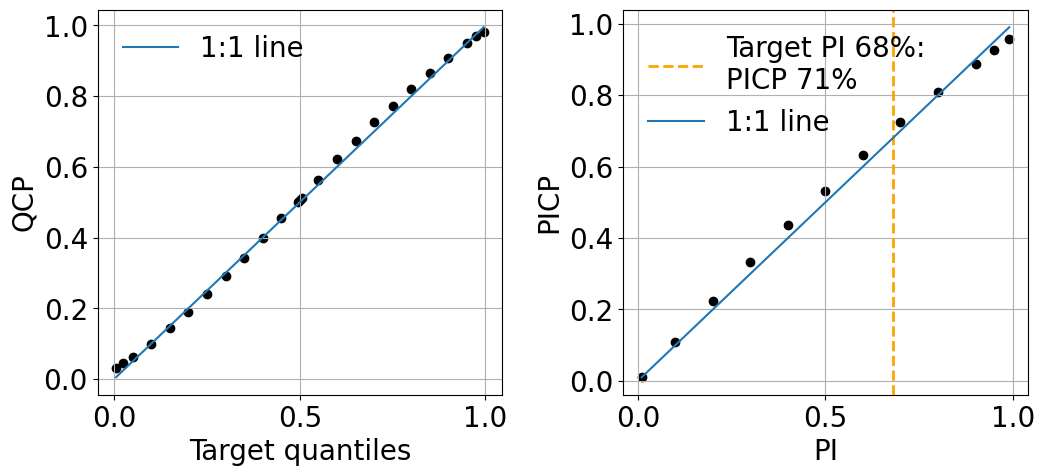

In [4]:
from trees_rf import cast_tree_rf
import matplotlib.pyplot as plt

for ii in range(0,len(prop_list)):    
    # define metadata------------------------------------------------------------
    prop = prop_list[ii]
    ttprint(f'processing {prop}-----------------------------------')
    space = space_list[ii]
    output_folder = data_path+'/'+prop
    os.makedirs(output_folder, exist_ok=True)
    
    if space=='log1p':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_log1p'
    elif space=='boxcox':
        # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
        tgt = f'{prop}_boxcox'
        cal[f'{prop}_boxcox'], fitted_lambda = boxcox(cal['ocd'], lmbda=None)
    else:
        tgt = prop
    
    # read in material--------------------------------------------------------------
    # data
    train = pd.read_parquet(f'{output_folder}/data_train_{prop}_v{version}.pq')
    test = pd.read_parquet(f'{output_folder}/data_test_{prop}_v{version}.pq')
    covs = read_features(f'{output_folder}/feature_selected_{prop}_v{version}.txt') # read in
    test = test.dropna(subset=covs,how='any')
    train = train.dropna(subset=covs,how='any')
    
    # models
    model = joblib.load(f'{output_folder}/model_rf.{prop}_ccc.joblib')
    model.n_jobs = 90
    model.fit(train[covs], train[tgt])
    model = cast_tree_rf(model)
    
    # tree predictions
    tree_predictions = model.predict(test[covs])
    y_pred = np.mean(tree_predictions, axis=0) # get the mean before transformation
    y_pred = np.expm1(y_pred)
    
    # calculate quantiles to form an accuracy plots
    if space == 'log1p':
        tree_predictions = np.expm1(tree_predictions) # tranform before getting the percentile
        
    quantiles = [0.005, 0.025, 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.495, 0.5 , 0.505, 0.55,
                 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 0.975, 0.995]
    y_q = np.percentile(tree_predictions, [q * 100 for q in quantiles], axis=0)
    qcp = []
    for ii in range(len(quantiles)):
        qcp.append(calc_qcp(y_q[ii], test[prop], quantiles[ii]))

    # calculate piw, picp
    pi = []
    picp = []
    piw_m = []
    piw_med = []
    for ii in range(12):
        jj = len(quantiles)-1-ii
        pi.append(round(1-quantiles[ii]*2,2))
        picp.append(calc_picp(y_q[ii,:], y_q[jj,:], test[prop]))
        piw_m.append(np.mean(y_q[jj,:]-y_q[ii,:]))
        piw_med.append(np.median(y_q[jj,:]-y_q[ii,:]))
        
    # calculate PICP for target PI (+- 1 std): 68%, P16-P84
    target_pi = [0.16, 0.84]
    pib = np.percentile(tree_predictions, [q * 100 for q in target_pi], axis=0)
    target_picp = calc_picp(pib[0], pib[1], test[prop])

    # plot
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=False)
    axs[0].plot(quantiles, quantiles, label='1:1 line')
    axs[0].scatter(quantiles, qcp, color='black')
    axs[0].set_xlabel('Target quantiles', fontsize=20)
    axs[0].set_ylabel('QCP', fontsize=20)
    axs[0].grid(True)
    axs[0].legend(fontsize=20, frameon=False)  # Make legend background transparent
    axs[0].tick_params(axis='both', which='major', labelsize=20)

    axs[1].axvline(x=0.68, color='orange', linestyle='--', linewidth=2, label=f'Target PI 68%:\nPICP {target_picp*100:.0f}%')  # Use axvline to draw a vertical line across the entire plot
    axs[1].plot(pi, pi, label='1:1 line')
    axs[1].scatter(pi, picp, color='black')
    axs[1].set_xlabel('PI', fontsize=20)
    axs[1].set_ylabel('PICP', fontsize=20)
    axs[1].grid(True)
    axs[1].legend(fontsize=20, frameon=False)  # Make legend background transparent
    axs[1].tick_params(axis='both', which='major', labelsize=20)

    plt.subplots_adjust(wspace=0.3)  
    plt.savefig(f'{output_folder}/plot_acuracy.uncertainty_{prop}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
